In [1]:
dataset_path = '/home/ycgao/Workdir/dataset/imagenet-mini/val'
qmodel_path = 'quantized.onnx'
model_path = 'origin.onnx'

In [2]:
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from onnxutils.common import DatasetUtils
from onnxutils.quantization.utils import symbolic_trace

from imagenet_pipeline import ImageNetPipeline
from qnn_quantizer import QnnQuantizer

# Prepare Model And Dataset

In [3]:
class M(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(3)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

In [4]:
dataset = ImageNetPipeline.get_dataset(dataset_path)
torch_model = M()
# torch_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Quantize

In [5]:
graph_model = symbolic_trace(torch_model)
quantizer = QnnQuantizer()

graph_model = quantizer.quantize(graph_model)
graph_model.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, x):
        # No stacktrace found for following nodes
        fq0 = self.fq0(x);  x = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv = self.conv(fq0);  fq0 = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        bn = self.bn(conv);  conv = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        relu = self.relu(bn);  bn = None
        
        # No stacktrace found for following nodes
        fq1 = self.fq1(relu);  relu = None
        
         # File: /opt/miniconda3/lib/python3.10/site-p

"class GraphModule(torch.nn.Module):\n    def forward(self, x):\n        # No stacktrace found for following nodes\n        fq0 = self.fq0(x);  x = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv = self.conv(fq0);  fq0 = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        bn = self.bn(conv);  conv = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        relu = self.relu(bn);  bn = None\n        \n        # No stacktrace found for following nodes\n        fq1 = self.fq1(relu);  relu = None\n        \n         # File: /opt/miniconda3/lib

# Qat

In [6]:
dataloader = DataLoader(
    DatasetUtils.take_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        2000
    ),
    batch_size=64
)
torch_model.to('cuda').eval()
graph_model.to('cuda').train()

loss_vals = []
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(graph_model.parameters(), lr=1e-5)
for _ in range(20):
    local_loss = 0
    for data in tqdm(dataloader):
        gt = torch_model(*data)
        pred = graph_model(*data)
    
        optimizer.zero_grad()
        loss = loss_fn(pred, gt)
        loss.backward()
        optimizer.step()

        local_loss += loss.detach().cpu().item()
    loss_vals.append(local_loss)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.51it/s]


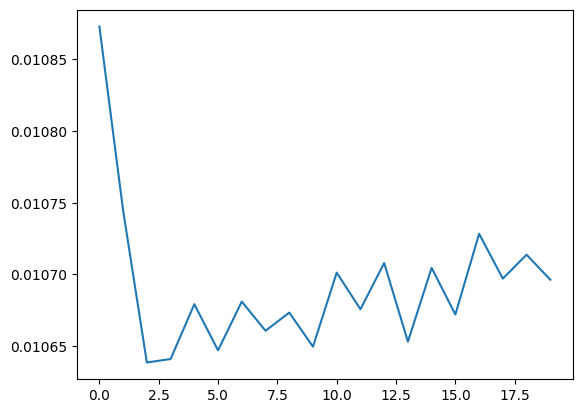

In [7]:
plt.plot(loss_vals)

# Eval

In [8]:
dataloader = DataLoader(
    DatasetUtils.drop_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        2000
    ),
    batch_size=64
)
torch_model.to('cuda').eval()
graph_model.to('cuda').eval()

for data in dataloader:
    gt = torch_model(*data)
    pred = graph_model(*data)

    gt_max = gt.max(dim=1, keepdim=True)[0]
    gt_min = gt.min(dim=1, keepdim=True)[0]
    gt_range = gt_max - gt_min

    diff = torch.sqrt(torch.pow(gt - pred, 2)).max(dim=1, keepdim=True)[0]
    ret = torch.cat([diff, gt_max, gt_min, gt_range, diff / gt_range], dim=1)
    print(ret)
    break

tensor([[[[2.8381e-02, 2.6537e-02, 2.5800e-02,  ..., 1.6797e-02,
           3.3309e-02, 1.5810e-02],
          [1.3445e-02, 3.8207e-02, 4.7398e-03,  ..., 2.1430e-02,
           2.9048e-02, 2.1460e-02],
          [1.6057e-02, 6.1021e-03, 1.9011e-02,  ..., 1.8260e-02,
           5.3442e-04, 3.5443e-02],
          ...,
          [8.6664e-03, 2.4868e-02, 8.0624e-03,  ..., 4.2383e-02,
           5.7721e-02, 5.9605e-02],
          [6.0315e-03, 1.6162e-02, 3.6726e-02,  ..., 0.0000e+00,
           4.2982e-02, 8.5255e-03],
          [3.5544e-03, 1.5276e-02, 3.2881e-03,  ..., 4.9928e-02,
           2.5257e-02, 3.3453e-02]],

         [[2.3895e+00, 2.4228e+00, 1.5129e+00,  ..., 6.4483e-01,
           4.5932e-01, 1.3347e+00],
          [1.5566e+00, 2.5189e+00, 2.1934e+00,  ..., 1.3089e+00,
           1.2223e+00, 1.2928e+00],
          [1.1458e+00, 3.0713e+00, 2.0915e+00,  ..., 1.0859e+00,
           9.7292e-01, 1.9823e+00],
          ...,
          [5.4249e-01, 8.2633e-01, 3.8488e-01,  ..., 2.9169

# Export

In [9]:
finalized_model = quantizer.finalize(graph_model)
finalized_model.to('cuda')

GraphModule(
  (conv): QuantizedConv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv1): QuantizedConv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
)

In [10]:
torch.onnx.export(
    finalized_model,
    tuple(next(iter(dataloader))),
    qmodel_path,
    input_names=['x'],
    output_names=['y'],
)
torch.onnx.export(
    torch_model,
    tuple(next(iter(dataloader))),
    model_path,
    input_names=['x'],
    output_names=['y'],
)